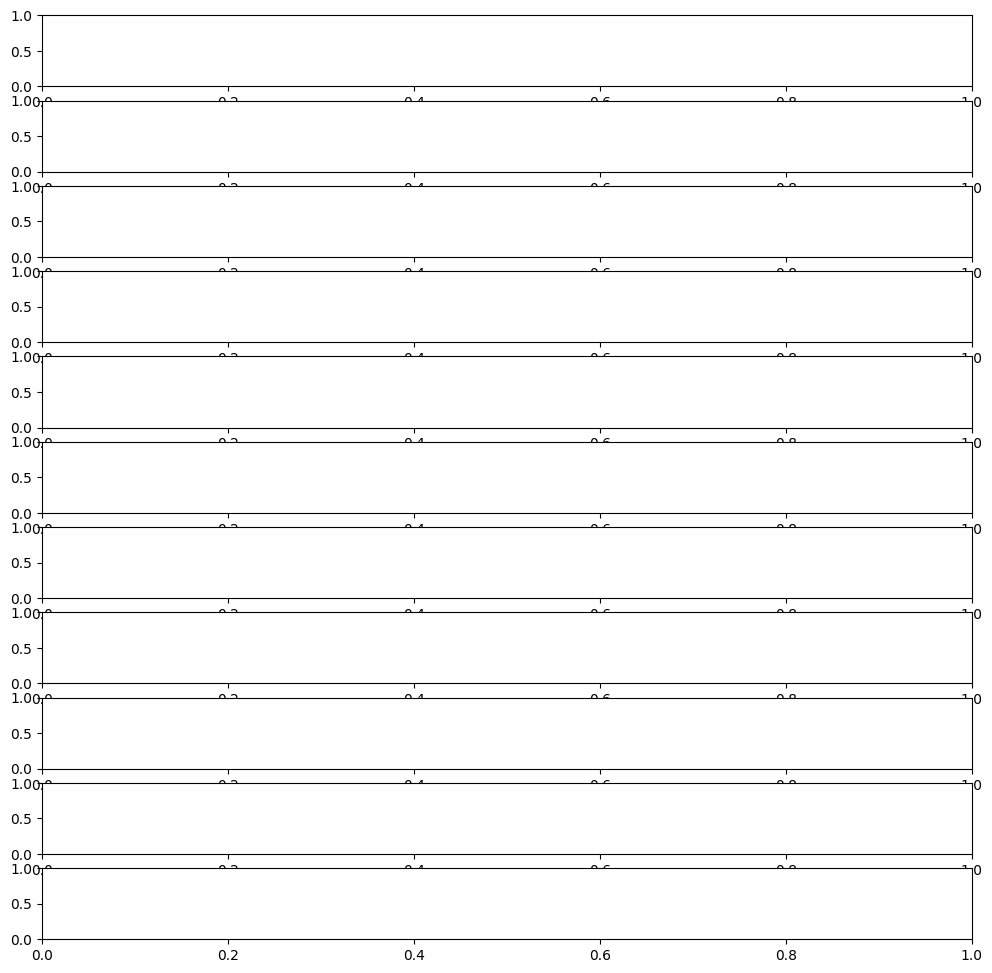

uri = wss://192.168.1.19
{'readings': {'pressure': 1270, 'pavg': 0, 'motor': 70, 'arousal': 48, 'millis': 293975, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 0, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}}
{'readings': {'pressure': 1290, 'pavg': 0, 'motor': 70, 'arousal': 46, 'millis': 294049, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 0, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}}
{'readings': {'pressure': 1299, 'pavg': 0, 'motor': 71, 'arousal': 43, 'millis': 294125, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 0, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}}
{'readings': {'pressure': 1284, 'pavg': 0, 'motor': 71, 'arousal': 41, 'millis': 294199, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 0, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}}
{'readings': {'pressure': 1266, 'pavg': 0, 'motor': 72, 'arousal': 38, 'millis': 294275, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 0, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}}
{'rea

In [7]:
import asyncio
import websockets
import ssl
import json
from datetime import datetime
import argparse
import signal

#process data into imfs
import emd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OneHotEncoder


# Handle asyncio event loop re-entry in Jupyter or similar environments
import nest_asyncio
nest_asyncio.apply()

# Global variable to handle cancellation
loop = asyncio.get_event_loop()
stop_event = asyncio.Event()

# global variables
pressure_values = []
motor_values = []
window_size = 100
num_imfs = 10
#epoch = 0

# Initialize the plot
plt.ion()  # Turn on interactive mode
fig, axes = plt.subplots(num_imfs + 1, 1, figsize=(12, 12)) # Adjust figure size as needed
plt.show()

async def connect_to_websocket(uri, output_file):
    ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    websocket = None
    file = None
    epoch = 0

    try:
        websocket = await websockets.connect(uri, ssl=ssl_context, ping_interval=None)

        # Send the request to start the stream
        start_stream_message = json.dumps({"streamReadings": 0})
        await websocket.send(start_stream_message)

        file = open(output_file, 'w')

        while not stop_event.is_set():
            try:
                message = await asyncio.wait_for(websocket.recv(), timeout=1)
                process_message(message)
                #epoch += 1
#                if epoch % 50 == 0:
#                    print(f"{message}")
            except asyncio.TimeoutError:
                continue
            except websockets.exceptions.ConnectionClosedError as e:
                print(f"Connexion fermée : {e}")
                break  # Exit the loop on disconnection
            except Exception as e:
                print(f"Erreur lors de la réception du message : {e}")
                break  # Exit the loop on other errors
    except asyncio.CancelledError:
        print("Task was cancelled, cleaning up...")
    except Exception as e:
        print(f"Erreur de connexion : {e}")
    finally:
        # Ensure the WebSocket connection is closed
        if websocket:
            await websocket.close()
            print("Connexion WebSocket fermée.")

        # Ensure the file is closed
        if file:
            file.close()
            print("Fichier de sortie fermé.")

def process_message(message):
    try:
        item = json.loads(message)
#        epoch += 1
#        if epoch % 50 == 0:
        if 'pressure' in item:
            print(f"{item}")
            pressure_values.append(item['pressure'])
            motor_values.append(item['motor'] / 255.0)  # Normalize motor values

            if len(pressure_values) >= window_size:
                # Calculate moving average
                moving_avg = np.convolve(pressure_values, np.ones(window_size), 'same') / window_size
                pressure_values_normalized = pressure_values - moving_avg

                # Extract IMFs
                imf = emd.sift.sift(np.array(pressure_values_normalized))
                imfs = imf[:, 1:]

                # Prepare dataset (consider adding other features if needed)
                dataset = np.hstack((imfs, np.array(motor_values).reshape(-1, 1)))

                # Use the dataset for your DQN model here
                # ...

                # Remove old data to maintain the window size
                pressure_values = pressure_values[1:]
                motor_values = motor_values[1:]

                # Update the plots
                # Plot the IMFs and motor speed
                num_imfs = imfs.shape[1]
                for i in range(num_imfs):
                    axes[i].clear()
                    axes[i].plot(imfs[:, i])
                    axes[i].set_title(f"IMF {i+1}")

                axes[num_imfs].clear()
                axes[num_imfs].plot(motor_values)
                axes[num_imfs].set_title('Motor Speed')

                fig.canvas.draw()
                fig.canvas.flush_events()


            runMode_values = np.array([item['runMode']])
            # One-hot encode runMode
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for numpy array
            runMode_encoded = encoder.fit_transform(runMode_values.reshape(-1, 1))

            arousal = np.array([item['arousal']])

            # Convert string booleans to integers
            permitOrgasm_values = np.array([1 if item['permitOrgasm'] == 'true' else 0])

    except json.JSONDecodeError:
        pass

    return None

def shutdown(signal_received, frame):
    print("Signal reçu pour l'arrêt.")
    stop_event.set()
    for task in asyncio.all_tasks(loop):
        task.cancel()

if __name__ == "__main__":
    uri = "wss://" + "192.168.1.19"

    print(f"uri = {uri}")
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"stream_output_{current_time}.txt"

    # Register the signal handler
    signal.signal(signal.SIGINT, shutdown)
    signal.signal(signal.SIGTERM, shutdown)

    try:
        loop.run_until_complete(connect_to_websocket(uri, output_file))
    except asyncio.CancelledError:
        pass
    finally:
        if not loop.is_running():
            loop.close()
        print("Programme arrêté.")
